In [5]:
#!pip install seaborn
#!pip install openpyxl
#!pip install pmdarima

In [6]:
import pandas as pd
import numpy as np
import random as rd
import time
import csv
import seaborn as sbs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split ,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from pmdarima.arima import auto_arima
from pmdarima.arima import StepwiseContext



In [7]:
# fix random seed for reproducibility
tf.random.set_seed(9)

In [8]:
# #from google.colab import drive
#drive.mount('/content/drive')
file_data = 'SN_m_tot_V2.0.csv'
path_name='../datasets/'
path_name_results='../results/'
file_result = 'Result_ARIMA_sunspot.csv'

In [9]:

dataset = pd.read_csv(f'{path_name}{file_data}', sep =';', encoding = 'latin1', decimal='.',usecols=[2,3])
dataset.columns = ['date','num_observations']
dataset.head()
#dataset = pd.read_csv(f'{path_name}{file_data}', sep =';', encoding = 'latin1', decimal='.')
#dataset.columns = ['year','month', 'date','total_sunspot_number','std_derivation','num_observations','def_prov_indicator']
#dataset.head()



,date,num_observations
0,1749.123,104.3
1,1749.204,116.7
2,1749.288,92.8
3,1749.371,141.7
4,1749.455,139.2


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3295 entries, 0 to 3294
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3295 non-null   float64
 1   num_observations  3295 non-null   float64
dtypes: float64(2)
memory usage: 51.6 KB


In [11]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

date                0
num_observations    0
dtype: int64

In [12]:
def salvar_resultado(nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration):
  #Script to write training cycle results
  data = [nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration]
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE', 'MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "a",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(data)  
  print(fields)
  print(data)
    
#Script to create the results file
def criar_arquivo_resultado():
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE','MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "w",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(fields)    

In [13]:
# convert an array of values into a dataset matrix
def create_matrix_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return np.array(df.drop(columns=['date','vl_0'])), np.array(df['vl_0'])

# convert dataset values into a dataset matrix
def create_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return df

In [14]:
  
def save_model(model,n_time_steps):
  # serialize model to JSON
  model_json = model.to_json()
  with open(f'{path_name_results}model_{n_time_steps}.json', "w") as json_file:
    json_file.write(model_json)

  # serialize weights to HDF5
  model.save_weights(f'{path_name_results}model_{n_time_steps}.h5')
  print("Saved model to disk")


In [15]:
def gera_resultado(y_test, predict,nm_dataset, resultado, n_time_steps, Duracao):
 #Mean Squared Error (Mean Squared Difference Between Estimated Values and Actual Values) - MSE
 MSE = mean_squared_error(y_test, predict)    
 #Square Root of Mean Error - RMSE
 RMSE = np.sqrt(mean_squared_error(y_test, predict))    
 #Mean Absolute Distance or Mean Absolute Error - MAE
 MAE= median_absolute_error(y_pred=predict, y_true = y_test) 
  
 #Calculate the MAPE (Mean Absolute Percentage Error)
 MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100   
  
 sMAPE = round(
 	np.mean(
 		np.abs(predict - y_test) /
 		((np.abs(predict) + np.abs(y_test)))
 	)*100, 2
 ) 
 salvar_resultado(nm_dataset, resultado, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duracao)
 return MAPE

array([<AxesSubplot:xlabel='date'>], dtype=object)

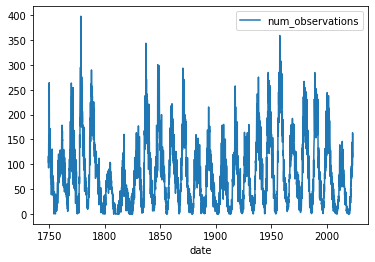

In [16]:
# indexing timestamp
dataset.set_index('date').plot(subplots=True)

In [17]:
n_time_steps = 2
nm_dataset = 'sunspot'
 
#Split dataset in treinam /  80% treinam  20% test
nlinhas = int(len(dataset) * 0.80)
test = dataset.iloc[nlinhas:len(dataset),:]  
train = dataset.iloc[0:nlinhas,:] 
#  reshape into X=t and Y=t+1 ot n_time_steps by steps
X_train, Y_train = create_matrix_dataset(train, n_time_steps)
X_test, Y_test = create_matrix_dataset(test, n_time_steps) 

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

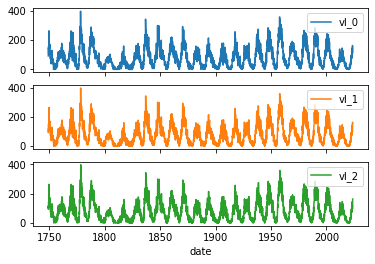

In [18]:
# indexing timeserires
ts_df=create_dataset(dataset, n_time_steps)
ts_df.set_index('date').plot(subplots=True)

In [19]:
Y_train = Y_train.reshape(-1,1)
Y_test=Y_test.reshape(-1,1)

# Armazena a hora de início da execução do Treinamento
Hora_Inicio = time.time()

# Estimate the differences number using ADF test
from pmdarima.arima.stationarity import ADFTest

# significance level alpha=0.05
ADF_test = ADFTest(alpha=0.05)
p_val, should_diff = ADF_test.should_diff(Y_train)  

if(should_diff):  # if  should_diff is true 
    d=should_diff
else: # if  should_diff is False
    d=0

p_val, d


(0.01, 0)

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


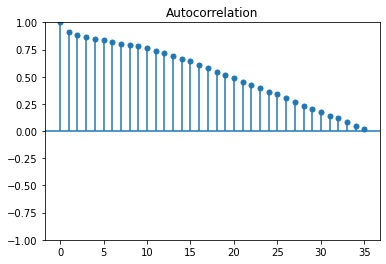

In [20]:
# autocorrelation test
import pmdarima as pm
pm.plot_acf(Y_train)


In [ ]:
with StepwiseContext(max_dur=50):
    model = auto_arima(Y_train, X = X_train, stepwise=True, error_action='ignore', d=d, seasonal=True, m=12, maxiter=500, start_p=0, start_q=0, max_p=9, max_q=9,trace=True,D=None)

Performing stepwise search to minimize aic


: 

In [4]:
# Search for best ARIMA hiperparams.
#with StepwiseContext(max_dur=50):
#    model = auto_arima(Y_train, X = X_train,
##                      seasonal=True, m=12, maxiter=500, d=d, 
#                      start_p=0, start_q=0, max_p=9, max_q=9, 
#                      D=None,             # let model determine 'D'
#                      trace=True,
#                      error_action='ignore',  
#                      suppress_warnings=True,
#                      stepwise=True)

NameError: name 'StepwiseContext' is not defined

In [ ]:
#print(model.params)
model.fit(Y_train)
resultado = model

# predictiong values
predict=model.predict(n_periods=Y_test.shape[0], X=X_test, alpha=0.05)
predict=predict.reshape(-1,1)

In [ ]:
#Validação dos resultados

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

#Erro médio quadrático  (diferença quadrática média entre os valores estimados e o valor verdadeiro) - MSE
mean_squared_error(Y_test,predict)

#Raiz quadrada do Erro médio - RMSE
np.sqrt(mean_squared_error(Y_test, predict))



68.13438691083084

In [ ]:
#Calcular o MAPE (Erro médio percentual absoluto)
MAPE = ((np.mean(np.abs(Y_test -predict) / (Y_test)))) * 100
MAPE

C:\Users\Edmilson\AppData\Local\Temp\ipykernel_13244\3381292061.py:2: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(Y_test -predict) / (Y_test)))) * 100


inf

<AxesSubplot:xlabel='date'>

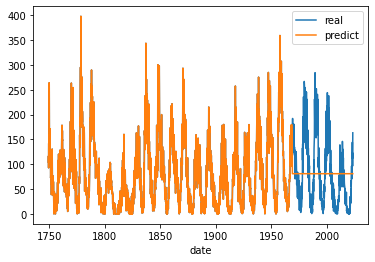

In [ ]:
df_predict = pd.DataFrame(predict)

new_df=pd.DataFrame()
total=nlinhas+len(df_predict)
new_df['real']=(dataset.iloc[0:total,1])
new_df['date']=dataset.iloc[0:total,0]
new_df['predict']=pd.concat([dataset.iloc[0:nlinhas,1],df_predict],ignore_index=True)
new_df.set_index('date').plot()

In [ ]:
new_df

,real,date,predict
0,104.3,1749.123,104.300000
1,116.7,1749.204,116.700000
2,92.8,1749.288,92.800000
3,141.7,1749.371,141.700000
4,139.2,1749.455,139.200000
...,...,...,...
3288,111.3,2023.122,83.247000
3289,123.3,2023.204,83.246991
3290,96.4,2023.286,83.246982
3291,137.9,2023.371,83.246973


In [ ]:
Hora_Fim = time.time()   
#Calculate the duration of the training execution
Duracao = Hora_Fim - Hora_Inicio   

#calc metrics of error and save in file
gera_resultado(Y_test, predict,nm_dataset, resultado, n_time_steps, Duracao)